In [88]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
from IPython.display import Image
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
print(os.listdir("../input"))

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# Any results you write to the current directory are saved as output.

['train', 'test', 'train.csv', 'sample_submission.csv']


* Let us begin this task. We wll develop simple model. Beginner friendly code !!!! YAY !!!!
* Doing the necessary imports.
* We will be using Keras with Data Augementation
* This time instead of building model from scratch we will do transfer learning.
* You can check the CNN from scratch here. https://www.kaggle.com/okeaditya/aerial-cactus-keras-cnn


In [89]:
train_dir="../input/train/train"
test_dir="../input/test/test"
train=pd.read_csv('../input/train.csv')

df_test=pd.read_csv('../input/sample_submission.csv')
train.has_cactus=train.has_cactus.astype(str)

In [90]:
train.tail(5)

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [91]:
train['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

*     Let us get a brief idea about the dataset that is given.
*     We have total of 17500 cactii images here.
*     We have a medium sized data-set.
*     Looks like we have a biased data-set. We have has_cactus for more data equal to 1.
*     This indicates that we have more images which have cactus.

## Reading the Images.


*     The main part is to handle the image data.
*     We need to take input of the image file
*     Decode the JPEG data into RGB channels
*     Then normalize it by dividing by 255.
*     We can do data-augmentation on top of that.
  
*    We can rotate the images by certain angle. (Using rotation_range)
*    We can also shift the images by a certain distance. (Using the width_shift_range and height_shift_range)
*    We can also try to horizontally flip the images.
*    I am not vertically flipping the image as it may mean an absurd view of aerial cactus.
*    Also finally we are rescaling it by a factor of 1./255 to normalize the pixel values.



In [92]:
train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, 
                             rotation_range= 55, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             brightness_range=None, 
                             shear_range=0.0, zoom_range=0.0, 
                             channel_shift_range=0.0, 
                             fill_mode='nearest',
                             cval=0.0, 
                             horizontal_flip=True, 
                             vertical_flip=False, 
                             rescale=1./255 , 
                             preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

*    Note while validating.
*    We do not want to check on augemented data.
*    We avoid checking on that by creating new validation generator and making use of it directly.


In [93]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [94]:
batch_size = 128

* Now we have to read the images with their labels which are in the train dataframe
* To do this Keras provides us the way of loading from dataframe using flow_from_dataframe
* Check it here https://keras.io/preprocessing/image/
* Also for a tutorial head here -> https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
* This also splits the data into two parts.
* We have 15000 images in train part.
* We have 2500 images in validation part.

In [95]:
train_generator = train_datagen.flow_from_dataframe(train[:15000], directory=train_dir, x_col='id', y_col='has_cactus', 
                    target_size=(64, 64), color_mode='rgb', classes=None, 
                    class_mode='binary', batch_size=batch_size, 
                    shuffle=True, seed=None, 
                    save_to_dir=None, save_prefix='', save_format='png', 
                    subset=None, interpolation='nearest', drop_duplicates=True)

Found 15000 validated image filenames belonging to 2 classes.


In [96]:
valid_generator = valid_datagen.flow_from_dataframe(train[15000:], directory=train_dir, x_col='id', y_col='has_cactus', 
                    target_size=(64, 64), color_mode='rgb', classes=None, 
                    class_mode='binary', batch_size=batch_size, 
                    shuffle=True, seed=None, 
                    save_to_dir=None, save_prefix='', save_format='png', 
                    subset=None, interpolation='nearest', drop_duplicates=True)

Found 2500 validated image filenames belonging to 2 classes.


## How does CNN work?

* Bulding a CNN is just like building our brain to recognize patterns. We try to focus only on certain featurs of image to understand that it is an aerial cactus. E.g seeing the green colour and spikes, considering its thickness might mean that we are seeing an aerial cactus.

* So we need to reduce the feature maps that are given in the image. This is done by Conv2D layer. We glide the 3x3 kernel over the entire image of size 256 x 256 multiple times. Thus we are reducing the dimensions of image while learning about them.

* We are thus making an abstract identification and description of an image.

## Transfer Learning

* Instead of building our own CNN architecture, we can try to use a pre-built CNN.
* The pre-built CNN is already trained on datasets such as ImageNet.
* So, it has certain ability to distinguish images quite well.
* This gives it a generalizing chracter. Lowers the variance.
* But we need to make it specialized on this dataset.
* For that we need to add a few layers a train these parameters so that it specializes.
* This ensures that bias is reduced, but variance is increased a bit, so we trade-off here.
* Keras provides various pre-trainied models which are traioned on ImageNet dataset.
* You can check them here -> https://keras.io/applications/

* We will try two most popular models here VGG16 and then ResNet

## Trying with VGG16

* Turn on the internet feature in Kaggle kernels.
* Also Turn on the GPU.
* You may need to re-reun the code.


In [97]:
# Making imports for VGG16
from keras.applications import VGG16

* We make include_top = False as we do not need the classifier of ImageNet.
* As this is binary_classification problem we set classes = 2
* Also our input size is 64 x 64 x 3. We need to specify that as well.

In [98]:
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(64,64,3), pooling=None, classes=2)

* Now we need to build a classifier on top of this.
* We then train the classifier.

In [99]:
base_model.summary()
# This is summary of VGG16

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [100]:
model = Sequential()
model.add(base_model)
# model.add(layers.Conv2D(32, kernel_size = (3,3), activation = 'relu')
# model.add(layers.Dropout())
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu' ))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [101]:
model.summary()
# Summary of model after adding the extra features to the base_model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 15,239,489
Trainable params: 15,239,489
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Let us find the trainable weights that we have
print("Number of trainable parameters before freezing the model ", len(model.trainable_weights))

Number of trainable parameters before freezing the model  30


In [103]:
# Now we freeze the base_model and train the extra two layers that we added
base_model.trainable = False
print("Number of trainable parameters after freezing the model ", len(model.trainable_weights))

Number of trainable parameters after freezing the model  4


In [104]:
# Let us re-summarize the model once
# We can see that some paramters are freezed and we have lot fewer models to train on
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               524544    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 257       
Total params: 15,239,489
Trainable params: 524,801
Non-trainable params: 14,714,688
_________________________________________________________________


* First we need to compile the model.
* Compiling the model has three parts, loss_function, optimizer and then the metrics.
* We want to minimize the binary_cross_entropy loss, since we are dealing with binary classification problem.
* Also we are using Adam optimizer.
* You could try different optimizer such as RMSProp or SGD also.
* https://keras.io/optimizers/ for details of all optimizers available
* To learn more http://ruder.io/optimizing-gradient-descent/
* We bother about accuracy score so we are using the metrics to be equalt to accuracy

In [105]:
# Let us create an optimizer, complie the model and train it
optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer = optim, loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
# Also let us checkpoint the model to keep track of best model
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
call_backs_list = [checkpoint]

In [107]:
max_epochs = 60
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = max_epochs,
    validation_data = valid_generator,
    callbacks = call_backs_list,
    validation_steps = 50.
)

Epoch 1/60
100/100 [==============================] - 44s 438ms/step - loss: 0.1928 - acc: 0.9223 - val_loss: 0.0881 - val_acc: 0.9707

Epoch 00001: val_acc improved from -inf to 0.97070, saving model to best_model.hdf5
Epoch 2/60
100/100 [==============================] - 24s 237ms/step - loss: 0.1005 - acc: 0.9624 - val_loss: 0.0675 - val_acc: 0.9756

Epoch 00002: val_acc improved from 0.97070 to 0.97556, saving model to best_model.hdf5
Epoch 3/60
100/100 [==============================] - 24s 238ms/step - loss: 0.0882 - acc: 0.9653 - val_loss: 0.0602 - val_acc: 0.9790

Epoch 00003: val_acc improved from 0.97556 to 0.97898, saving model to best_model.hdf5
Epoch 4/60
100/100 [==============================] - 24s 237ms/step - loss: 0.0785 - acc: 0.9693 - val_loss: 0.0578 - val_acc: 0.9773

Epoch 00004: val_acc did not improve from 0.97898
Epoch 5/60
100/100 [==============================] - 24s 238ms/step - loss: 0.0725 - acc: 0.9730 - val_loss: 0.0553 - val_acc: 0.9799

Epoch 00005:

KeyboardInterrupt: 

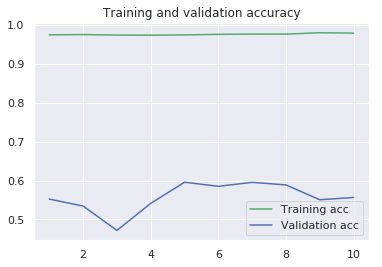

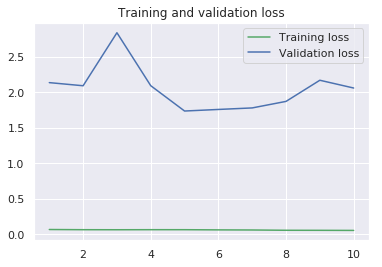

In [109]:
# Let us check the plot once. 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [110]:
# Reload the best model
model.load_weights("best_model.hdf5")
model.compile(optimizer = optim, loss='binary_crossentropy', metrics=['accuracy'])

## Trying DenseNet121

* Let us try one more model DenseNet121
* We are trying to compare the two performances and the choose the better model of the two.
* The proedure remains same, we will use pre-trained model of ResNet. 
* Then flatten and add a densely connected layer. On top of that we will have the output layer.

In [111]:
from keras.applications.densenet import DenseNet121

In [112]:
base_layer = DenseNet121(include_top=False, weights='imagenet', input_tensor=None, input_shape=(64,64,3), pooling=None, classes=2)

* Let us quickly summarize how DenseNet121 looks like

In [ ]:
base_layer.summary()

In [ ]:
model2 = Sequential()
model2.add(base_layer)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation = 'relu'))
model2.add(layers.Dense(1, activation = 'sigmoid'))
model2.summary()

In [ ]:
# Now we freeze the base_model and train the extra two layers that we added
base_layer.trainable = False
model2.summary()

In [ ]:
optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model2.compile(optimizer = optim, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Also let us checkpoint the model to keep track of best model
filepath = "best_model_DenseNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
call_backs_list = [checkpoint]

In [ ]:
max_epochs = 10
history = model2.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = max_epochs,
    validation_data = valid_generator,
    callbacks = call_backs_list,
    validation_steps = 50.
)

In [ ]:
# Let us check the plot once. 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

* So the DenseNet model does not genaralize well.
* Let us use only the VGG16 for making final predicitions.

In [113]:
un_test_img=[]
count=0
for i in os.listdir("../input/test/test/"):
    un_test_img.append(i)
    count+=1
un_test_image=[]
for i in tqdm(range(count)):
    img = image.load_img('../input/test/test/'+un_test_img[i], target_size=(64,64,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    un_test_image.append(img)
un_test_img_array = np.array(un_test_image)

100%|██████████| 4000/4000 [00:05<00:00, 749.34it/s]


In [114]:
output = model.predict_classes(un_test_img_array)

In [115]:
submission_save = pd.DataFrame()
submission_save['id'] = un_test_img
submission_save['has_cactus'] = output
submission_save.to_csv('submission.csv', header=True, index=False)

In [116]:
pd.read_csv('submission.csv')

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,1
1,da498fc860c8b76ca925c4218c5f0373.jpg,1
2,433052030eeb117e4bd8f6ce033c9da4.jpg,1
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,1
5,873191a1575a6292ed92714bfc659b87.jpg,1
6,8f99b87b7a652d68232fbd6379529368.jpg,0
7,316e46903ee485aeecfd229973abcc71.jpg,0
8,fc76ae520f30c6aba6dbfa8e82def89c.jpg,1
9,ee3ddba5f04e0674db0d18a9dd3b8131.jpg,1
